In [1]:
import os
import torch

ssh_config = """
Host github.com
  IdentityFile ~/.ssh/github.pem
  User davipeag
  StrictHostKeyChecking no
"""

if os.name == 'nt':
  base_path = ""
  REPO_DIR = "."
  print("Windows")
else:
  print("Unix-like")
  REPO_DIR = "/tmp/dissertation"
  from google.colab import drive
  drive.mount('/content/drive')
  GIT_PATH = "/content/drive/My\ Drive/deeplearning_project/github.pem"
  DATA_PATH = "/content/drive/My\ Drive/deeplearning_project/normalized.zip"
  !mkdir ~/.ssh
  !cp -u {GIT_PATH} ~/.ssh/
  !chmod u=rw,g=,o= ~/.ssh/github.pem
  !echo "{ssh_config}" > ~/.ssh/config
  !chmod u=rw,g=,o= ~/.ssh/config
  ! (cd /tmp && git clone git@github.com:davipeag/dissertation.git )
  ! (cd /tmp/dissertation/ && git pull )
  import sys
  sys.path.append("/tmp/dissertation")


def git_push():
  if os.name == 'nt':
    pass
  else:
    ! git config --global user.email "daviaguiar@outlook.com"
    ! git config --global user.name "Davi Pedrosa de Aguiar"
    print("going to push")
    ! (cd /tmp/dissertation && git pull && cd -)
    ! (cd /tmp/dissertation && git add . && git commit -m "from colab" && git push)

def git_pull():
  if os.name == 'nt':
    pass
  else:
    ! git config --global user.email "daviaguiar@outlook.com"
    ! git config --global user.name "Davi Pedrosa de Aguiar"
    print("going to push")
    ! (cd /tmp/dissertation && git pull && cd -)
    
  
git_push()


Windows


In [2]:
args = {
    'epoch_num': 250,     # Number of epochs.
    'lr': 1.0e-3,           # Learning rate.
    'weight_decay': 10e-4, # L2 penalty.
    'momentum': 0.9,      # Momentum.
    'num_workers': 0,     # Number of workers on data loader.
    'batch_size': 5,     # Mini-batch size. 600
    'batch_test': 248,     # size of test batch
    'window': 15,
    'initial_window':5,
    'clip_norm': 6.0,     # Upper limit on gradient L2 norm ###
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cpu


In [3]:
import pandas as pd
! pip install wget 


from data_utils import Pamap2Handler


dataset_handler = Pamap2Handler(os.path.join(REPO_DIR, ".."))


dfs = [dataset_handler.get_protocol_subject(s) for s in [1,2,3,4,5,6,7,8]]
df_full = pd.concat(dfs)



You should consider upgrading via the 'c:\python37\python.exe -m pip install --upgrade pip' command.


In [4]:
from preprocessing_utils import (
    RecursiveHrMasker,
    LabelCumSum,
    LinearImputation,
    HZMeanSubstitute,
    DeltaHzToLabel,
    NormalizeDZ,
    LocalMeanReplacer,
    ZTransformer,
    ImputeZero,
    ActivityIdRelabeler,
    Downsampler,
    FeatureLabelSplit,
    TimeSnippetAggregator,
    RemoveLabels,
    SampleMaker,
    InitialStatePredictionSplit,
    TransformerPipeline
)


recursive_hr_masker = RecursiveHrMasker(0)

label_cum_sum = LabelCumSum()

hr_lin_imputation = LinearImputation("heart_rate")

meansub = HZMeanSubstitute()
deltahztolabel = DeltaHzToLabel()
normdz = NormalizeDZ()

local_mean_imputer = LocalMeanReplacer()
ztransformer = ZTransformer()
zero_imputer = ImputeZero()
activity_id_relabeler = ActivityIdRelabeler()
downsampler = Downsampler()
feature_label_splitter = FeatureLabelSplit(
    feature_columns = [
          'heart_rate', 'h_temperature', 'h_xacc16', 'h_yacc16', 'h_zacc16',
          'h_xacc6', 'h_yacc6', 'h_zacc6', 'h_xgyr', 'h_ygyr', 'h_zgyr', 'h_xmag',
          'h_ymag', 'h_zmag', 'c_temperature', 'c_xacc16', 'c_yacc16', 'c_zacc16',
          'c_xacc6', 'c_yacc6', 'c_zacc6', 'c_xgyr', 'c_ygyr', 'c_zgyr', 'c_xmag',
          'c_ymag', 'c_zmag', 'a_temperature', 'a_xacc16', 'a_yacc16', 'a_zacc16',
          'a_xacc6', 'a_yacc6', 'a_zacc6', 'a_xgyr', 'a_ygyr', 'a_zgyr', 'a_xmag',
          'a_ymag', 'a_zmag']
)
ts_aggregator = TimeSnippetAggregator(size=300)
label_remover = RemoveLabels([0])

ts_per_sample = 162#642#162# 642#322
ts_per_is = 2


sample_maker = SampleMaker(ts_per_sample, ts_per_sample//2)

sample_maker_ts = SampleMaker(ts_per_sample, ts_per_sample)

is_pred_split = InitialStatePredictionSplit(ts_per_sample, ts_per_is)

transformers = TransformerPipeline(ztransformer, hr_lin_imputation, local_mean_imputer,
                                   activity_id_relabeler,
                                   feature_label_splitter,
                                   ts_aggregator, meansub, deltahztolabel, normdz,
                                   sample_maker, label_cum_sum, is_pred_split, recursive_hr_masker)

transformers_ts = TransformerPipeline(ztransformer, hr_lin_imputation, local_mean_imputer,
                                   activity_id_relabeler,
                                   feature_label_splitter,
                                   ts_aggregator, meansub, deltahztolabel, normdz,
                                   sample_maker_ts, label_cum_sum, is_pred_split,recursive_hr_masker)


transformers.fit(df_full)

from data_utils import cross_validation_split



val_sub = 2


xy_tr, xy_val, xy_ts = cross_validation_split(dfs, transformers, transformers_ts, transformers_ts, val_sub,4)

# train_ts = [0,1,2,3,5,6,7] 

# val_idx = train_ts.index(val_sub)
# train_idxes = train_ts[:val_idx] + train_ts[val_idx+1:] 

# xy_tr = [transformers.transform(dfs[i]) for i in train_idxes]
# xy_val = [transformers_ts.transform(df) for df in dfs[4:5]]
# xy_ts = [transformers_ts.transform(dfs[i]) for i in [val_sub]]
# #xys_optional_t= [transformers.transform(df) for df in dfs_test]
# print(train_idxes)
# print(val_sub)



In [5]:
from models_utils import OurConvLstmDataset, make_loader, reset_seeds

reset_seeds()


loader_tr = make_loader(xy_tr, OurConvLstmDataset, batch_size=args["batch_size"], shuffle=True)
loader_val = make_loader(xy_val, OurConvLstmDataset, batch_size=args["batch_test"],shuffle=False)
loader_ts = make_loader(xy_ts, OurConvLstmDataset, batch_size=args["batch_test"], shuffle=False)


In [6]:
from default_utils import make_our_conv_lstm
from torch import nn

net = make_our_conv_lstm(40, 1).to(args["device"])
criterion = nn.L1Loss().to(args["device"]) 
optimizer = torch.optim.Adam(net.parameters(), lr=args["lr"],
                             weight_decay=args["weight_decay"])

In [7]:
from models_utils import get_n_params
  
get_n_params(net)

64097

Test


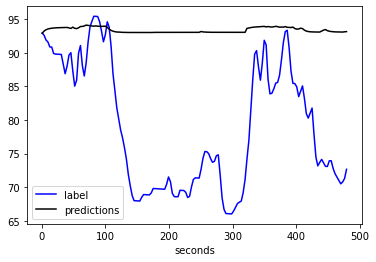

Validation


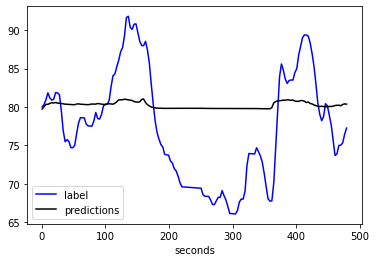

Train


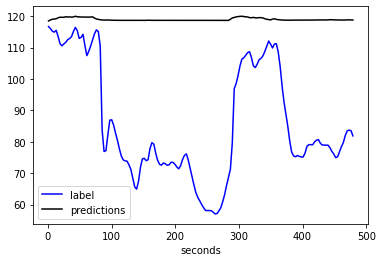

(13.712064, 13.248799, 11.826775, tensor(7.0462))

In [10]:
from default_utils import TrainOurConvLSTM  


trainer = TrainOurConvLSTM(
        net,
        criterion,
        optimizer,
        loader_tr,
        loader_val,
        normdz,
        ztransformer,
        device = args["device"]
)

print("Test")
trainer.plot_heart_rate(loader_ts)
print("Validation")
trainer.plot_heart_rate(loader_val)
print("Train")
trainer.plot_heart_rate(loader_tr)
trainer.compute_mean_MAE(loader_tr), trainer.compute_mean_MAE(loader_ts), trainer.compute_mean_MAE(loader_val), trainer.validate()


#trainer.HR_MAE(x,y,p), trainer.HR_RMSE(x,y,p)


In [11]:
%%time
import numpy as np

import copy
best_val_model = copy.deepcopy(net.state_dict()) 

n_epoch = args["epoch_num"]
train_losses = list()
train_accuracies = list()
validation_losses = list()
validation_accuracies = list()
test_accuracies = list()

validation_losses.append(trainer.compute_mean_MAE(loader_val))

for epoch in range(1, n_epoch+1):           
    losses = []
    for batch_idx, batch in enumerate(loader_tr):
        losses.append(trainer.train(batch))

    val_loss = trainer.compute_mean_MAE(loader_val) 
    if val_loss < np.min(validation_losses):
      print("best val epoch:", epoch)
      best_val_model = copy.deepcopy(trainer.net.state_dict()) 

    train_losses.append(torch.mean(torch.FloatTensor(losses)) )
    validation_losses.append(val_loss)
    train_accuracies.append(trainer.compute_mean_MAE(loader_tr))
    validation_accuracies.append(val_loss)
    test_accuracies.append(trainer.compute_mean_MAE(loader_ts))   
    print('[%d/%d]: loss_train: %.3f loss_val %.3f loss_ts %.3f' % (
            (epoch), n_epoch, train_accuracies[-1],
            validation_accuracies[-1], test_accuracies[-1]))
    
    if (epoch % 10) == 0:
      print("Test")
      trainer.plot_heart_rate(loader_ts)
      print("Validation")
      trainer.plot_heart_rate(loader_val)
      print("Train")
      trainer.plot_heart_rate(loader_tr)
      trainer.compute_mean_MAE(loader_ts)

3


NameError: name 'np' is not defined